In [1]:
from skimage.measure import compare_ssim
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa
from matplotlib import cm
from matplotlib.colors import hsv_to_rgb
import imutils

In [2]:
# takes two images and finds the SSIM between them
# returns the score back to main
def compareImages(gray1, gray2):
    # compute the Structural Similarity Index (SSIM) between the two
    # images, ensuring that the difference image is returned
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    diff = (diff * 255).astype("uint8")
    
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(gray1, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(gray2, (x, y), (x + w, y + h), (0, 0, 255), 2)

    plt.imshow(diff)
    plt.show()
    plt.imshow(thresh)
    plt.show()
    plt.imshow(gray1)
    plt.show()
    plt.imshow(gray2)
    plt.show()
    return score

In [3]:
# returns an undistorted image
def undistort(img, balance=0.0, dim2=None, dim3=None):
    K = np.array(
        [[318.5047565963465, 0.0, 304.72174448074446], [0.0, 318.3070269260298, 234.84280567757642], [0.0, 0.0, 1.0]])
    D = np.array([[-0.041193383831182505], [0.012582938251747337], [-0.026474498577198458], [0.020393209710516367]])
    DIM = (480, 640)  # image dimensions

    dim1 = img.shape[:2][::-1]  # dim1 is the dimension of input image to undistort

    if not dim2:
        dim2 = dim1

    if not dim3:
        dim3 = dim1

    scaled_K = K * dim1[0] / DIM[0]  # The values of K is to scale with image dimension
    scaled_K[2][2] = 1.0

    new_K = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(scaled_K, D, dim2, np.eye(3), balance=balance)
    map1, map2 = cv2.fisheye.initUndistortRectifyMap(scaled_K, D, np.eye(3), new_K, dim3, cv2.CV_16SC2)
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

    return undistorted_img

In [4]:
# returns a masked version of the input image, removes any brightly lit areas
def maskImage(img):
    # will be used to threshold certain colors
    light_blue = (0, 0, 50)
    dark_blue = (180, 255, 150)

    # converts the input image to HSV color scheme
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # masks with 1 if in the range, 0 if not
    mask = cv2.inRange(hsv_img, light_blue, dark_blue)

    return cv2.bitwise_and(img,img,mask=mask)

In [5]:
video = "..\\..\\Desktop\\boiling_short.h264"

cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 6000): # should be boiling
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

### Captured consecutive images of boiling

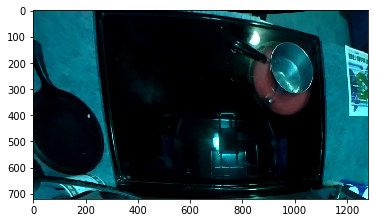

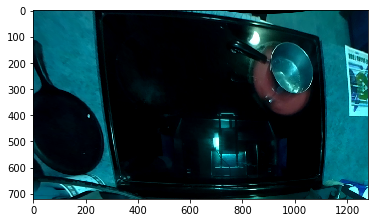

In [6]:
# uses the calibration matrices to process the video
calibrated1 = undistort(captured)
calibrated2 = undistort(captured2)
plt.imshow(calibrated1)
plt.show()
plt.imshow(calibrated2)
plt.show()

### Display erosion and dilation versions of first frame

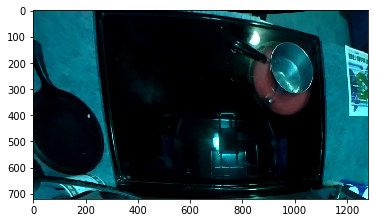

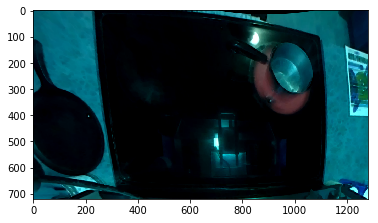

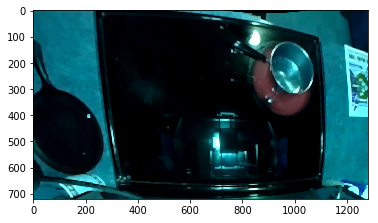

In [7]:
kernel = np.ones((5,5), np.uint8)

img_erosion1 = cv2.erode(calibrated1, kernel, iterations=1)
img_dilation1 = cv2.dilate(calibrated1, kernel, iterations=1)

plt.imshow(calibrated1)
plt.show()
plt.imshow(img_erosion1)
plt.show()
plt.imshow(img_dilation1)
plt.show()

### Display erosion and dilation versions of second frame

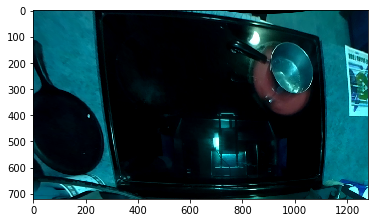

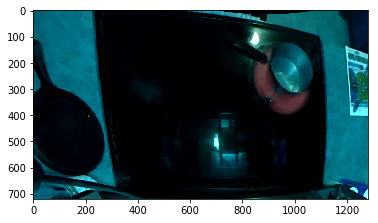

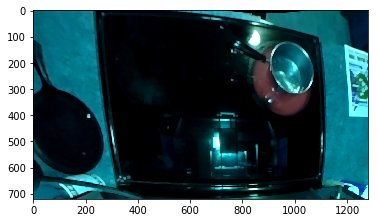

In [8]:
kernel = np.ones((5,5), np.uint8)

img_erosion2 = cv2.erode(calibrated2, kernel, iterations=1)
img_dilation2 = cv2.dilate(calibrated2, kernel, iterations=1)

plt.imshow(calibrated2)
plt.show()
plt.imshow(img_erosion2)
plt.show()
plt.imshow(img_dilation2)
plt.show()

### Masked versions of the images

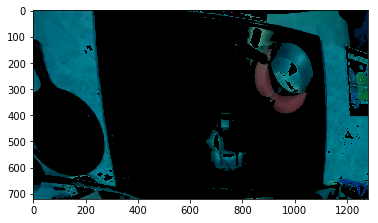

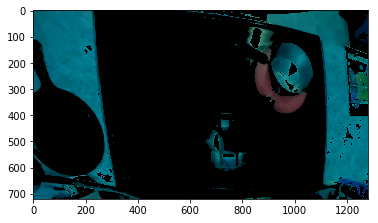

In [9]:
# gets a masked version of the images
mask1 = maskImage(img_erosion1)
mask2 = maskImage(img_erosion2)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

### Grayscale conversion of images

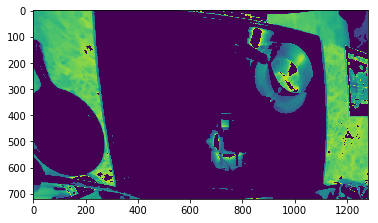

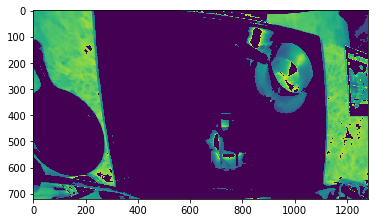

In [10]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

### Comparison between the two eroded images

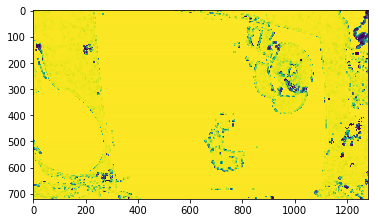

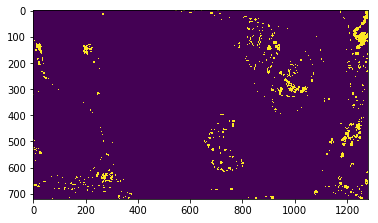

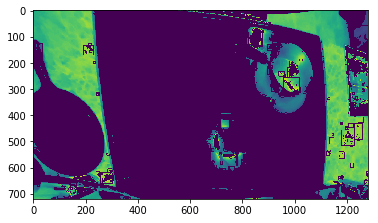

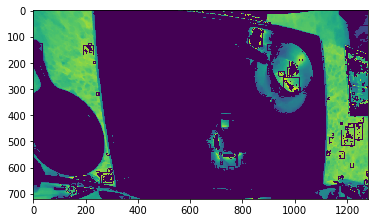


SSIM: 0.9714667884490218


In [11]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated

## Repeat of above process with frames of water boiling more aggressively

In [12]:
video = "..\\..\\Desktop\\boiling_short.h264"

cap = cv2.VideoCapture(video)

frameCount = 0 # wait till at a stable beginning
initial = True
while cap.isOpened():
    retTemp, frameTemp = cap.read();

    # if it is the first time then two frames must be recorded
    if initial:
        ret1 = retTemp
        frameOld = frameTemp
        ret2, frameNew = cap.read()
        initial = False
        frameCount += 1
    elif(frameCount == 8000): # should be boiling
        captured = frameNew
        captured2 = frameTemp
        frameCount += 1
        break
        # checks the frame count to see if time to collect a new one
    else:
        ret1 = ret2
        frameOld = frameNew
        ret2 = retTemp
        frameNew = frameTemp
        frameCount += 1

cap.release()

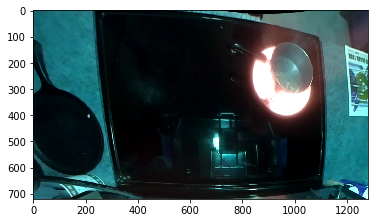

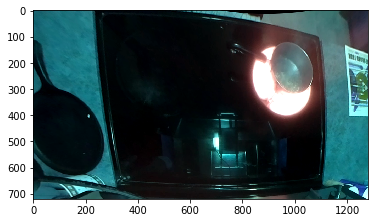

In [13]:
# uses the calibration matrices to process the video
calibrated1 = undistort(captured)
calibrated2 = undistort(captured2)
plt.imshow(calibrated1)
plt.show()
plt.imshow(calibrated2)
plt.show()

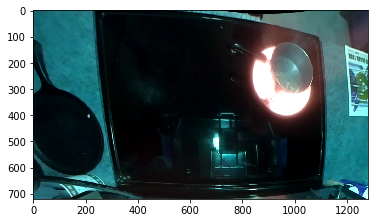

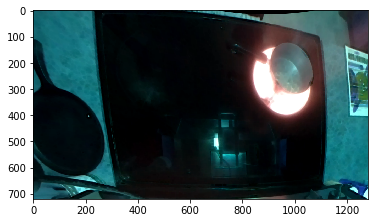

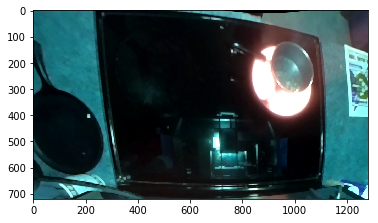

In [14]:
kernel = np.ones((5,5), np.uint8)

img_erosion1 = cv2.erode(calibrated1, kernel, iterations=1)
img_dilation1 = cv2.dilate(calibrated1, kernel, iterations=1)

plt.imshow(calibrated1)
plt.show()
plt.imshow(img_erosion1)
plt.show()
plt.imshow(img_dilation1)
plt.show()

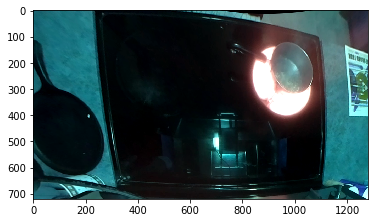

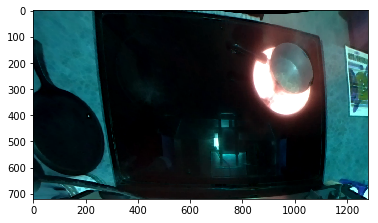

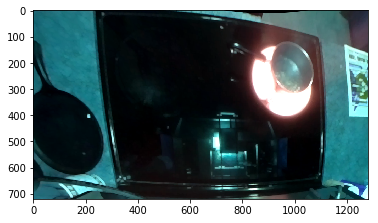

In [15]:
kernel = np.ones((5,5), np.uint8)

img_erosion2 = cv2.erode(calibrated2, kernel, iterations=1)
img_dilation2 = cv2.dilate(calibrated2, kernel, iterations=1)

plt.imshow(calibrated2)
plt.show()
plt.imshow(img_erosion2)
plt.show()
plt.imshow(img_dilation2)
plt.show()

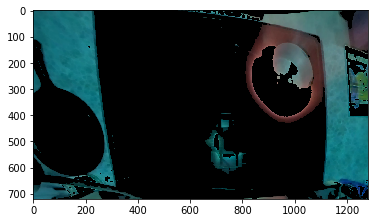

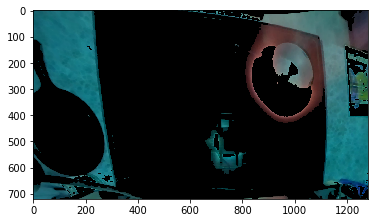

In [16]:
# gets a masked version of the images
mask1 = maskImage(img_erosion1)
mask2 = maskImage(img_erosion2)

plt.imshow(mask1)
plt.show()
plt.imshow(mask2)
plt.show()

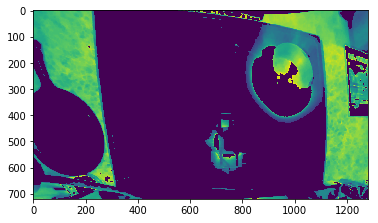

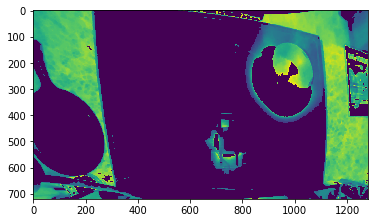

In [17]:
# converts the masked images images to grayscale
gray1 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(mask2, cv2.COLOR_BGR2GRAY)

plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

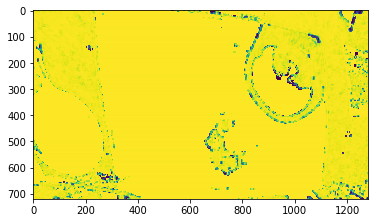

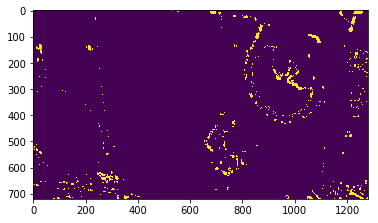

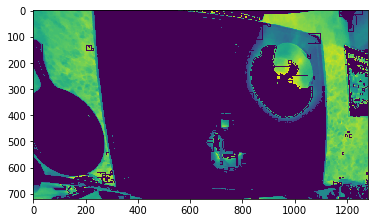

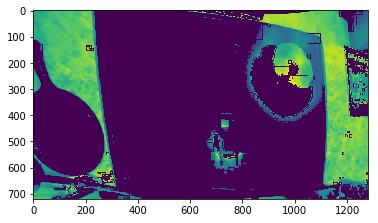


SSIM: 0.9747758634927893


In [18]:
# compare the two images
score = compareImages(gray1, gray2)
print("\nSSIM: {}".format(score))  # record the score that was calculated